In [1]:
# https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb

import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px


data_dir = 'dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

# fig, axs = plt.subplots(5, 5, figsize=(8,8))
# for ax in axs.flatten():
#     # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
#     img, label = random.choice(train_dataset)
#     ax.imshow(np.array(img), cmap='gist_gray')
#     ax.set_title('Label: %d' % label)
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.tight_layout()
# plt.show()

train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

m = len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        #self.flatten = torch.flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = torch.flatten(x, start_dim=1)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )


        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x


### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 0.001 # Learning rate

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)


def add_noise(inputs,noise_factor=0.3):
     noise = inputs+torch.randn_like(inputs)*noise_factor
     noise = torch.clamp(noise,0.,1.)
     return noise


### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_noisy)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


def plot_ae_outputs_den(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[i][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()


### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    # plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)





/Users/matteoblack/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/matteoblack/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/matteoblack/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/matteoblack/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


EPOCH 1/30

 EPOCH 1/30 	 train loss 0.123 	 val loss 0.065
EPOCH 2/30

 EPOCH 2/30 	 train loss 0.054 	 val loss 0.046
EPOCH 3/30

 EPOCH 3/30 	 train loss 0.041 	 val loss 0.037
EPOCH 4/30

 EPOCH 4/30 	 train loss 0.035 	 val loss 0.034
EPOCH 5/30

 EPOCH 5/30 	 train loss 0.033 	 val loss 0.032
EPOCH 6/30

 EPOCH 6/30 	 train loss 0.031 	 val loss 0.031
EPOCH 7/30

 EPOCH 7/30 	 train loss 0.030 	 val loss 0.030
EPOCH 8/30

 EPOCH 8/30 	 train loss 0.030 	 val loss 0.030
EPOCH 9/30

 EPOCH 9/30 	 train loss 0.029 	 val loss 0.029
EPOCH 10/30

 EPOCH 10/30 	 train loss 0.029 	 val loss 0.029
EPOCH 11/30

 EPOCH 11/30 	 train loss 0.029 	 val loss 0.029
EPOCH 12/30

 EPOCH 12/30 	 train loss 0.028 	 val loss 0.028
EPOCH 13/30

 EPOCH 13/30 	 train loss 0.028 	 val loss 0.028
EPOCH 14/30

 EPOCH 14/30 	 train loss 0.028 	 val loss 0.028
EPOCH 15/30

 EPOCH 15/30 	 train loss 0.028 	 val loss 0.028
EPOCH 16/30

 EPOCH 16/30 	 train loss 0.028 	 val loss 0.028
EPOCH 17/30

 EPOCH 17/30 

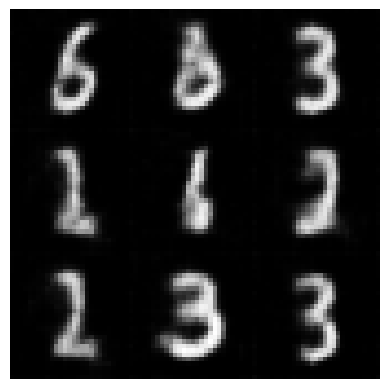

In [51]:
# Put your image generator here
random_imgs = list()
for i in range(9):
    with torch.no_grad():
        tensor = torch.rand((1, d))
        image  = decoder(tensor).detach().squeeze().numpy()
        random_imgs.append(image)

img_num = 0
matrix = np.zeros((28*3, 28*3))
for i in range(3):
    for j in range(3):
        matrix[i*28 : (i+1)*28, j*28 : (j+1)*28] = random_imgs[img_num]
        img_num += 1
plt.imshow(matrix, cmap='gist_gray')
plt.axis('off')
plt.savefig('/Users/matteoblack/Desktop/Proj/proj-NN-2023-2024/06-HW/plot/gen.png', dpi=400, bbox_inches='tight', transparent=True)



In [2]:
# Put your clustering accuracy calculation here
from sklearn.cluster import KMeans

X = list()
labels = list()
for image, label in torch.utils.data.DataLoader(train_data, batch_size=1):
    enc = encoder(image).detach().squeeze().numpy()
    X.append(enc)
    labels.append(label.item())

X = np.array(X)
labels = np.array(labels)

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X)
cluster_assignments = kmeans.labels_

In [4]:

accuracy = 0
for i in range(10):
    mask = labels == i
    
    unique, counts = np.unique(cluster_assignments[mask], return_counts=True)
    counts = dict(zip(unique, counts))
    tot = 0
    tp = 0
    for c in counts:
        tot += counts[c]
        if counts[c] >= tp:
            tp = counts[c]
    accuracy += tp

print(f'Accuracy clustering: {(accuracy/X.shape[0])*100:.2f}')

Accuracy clustering: 78.47


In [3]:
accuracy = 0
mapping = np.zeros((10, 10))
for i in range(X.shape[0]):
    mapping[labels[i].item()][cluster_assignments[i]] += 1

matched = list()
for i in range(10):
    matched.append(np.argmax(mapping[i, :]))

i = 0
while i < 10:
    j = 0
    while j < 10:
        if matched[i] == matched[j] and i != j:
            if mapping[i][int(matched[i])] > mapping[j][int(matched[j])]:
                mapping[j][int(matched[j])] = -1
                matched[j] = np.argmax(mapping[j, :])
                i = -1
                break
        j+=1
    i+=1

for i, m in enumerate(matched):
    accuracy += mapping[i][m]
    
print(f'Accuracy clustering: {(accuracy/X.shape[0])*100:.2f}%')
print(f'Mapping clustering: {matched}')


Accuracy clustering: 66.74
Mapping clustering: [6, 4, 1, 9, 3, 7, 5, 8, 2, 0]
